### Objetivo: Lectura y procesamiento de listado de productos de humedad de suelo disponible en catálogo de CONAE
### Fecha: 08/08/2024
### Autor: Gustavo V. Diaz
ref: [Catálogo CONAE](https://catalog.saocom.conae.gov.ar/catalog/#/)

**Descripción de objetivo**

Obtener los productos que tomen la totalidad de la ROI ingresada y ordenar el listando en función de dicho parámetro. \
Como ordenamiento posterior primero elgir las escenas de modo Stripmap y en segundo orden las escenas TOPSAR. \
Finalmente informar las fechas disponibles de análisis para cada uno de los modos

**Definición de carpeta de entrada** \
En la carpeta de entrada se de deben ingresar los siguientes archivos:
* _xlsx_ de búsqueda
* _kml_ de la búsqueda original

**Definición de salida** \
Luego del procesamiento en la carpeta de salida se de debe encontrar la siguiente planilla de cálculo:
* Solapa _completa_: Se va a encontrar la totalidad de los productos encontrados ordenados por porcentaje de intersección de ROI y un segundo criterio de orden será la fecha de adquisición
* Solapa _Stripmap_: Se va a encontrar la totalidad de los productos STRIPMAP encontrados ordenados por porcentaje de intersección de ROI y como segundo criterio de orden la fecha de adquisición
* Solapa _TOPSAR_: Se va a encontrar la totalidad de los productos TOPSAR encontrados ordenados por porcentaje de intersección de ROI y como segundo criterio de orden la fecha de adquisición

In [19]:
import pandas as pd
import os

import geopandas as gpd, geoplot, matplotlib
from shapely.geometry import shape
from shapely import wkt
import fiona
# Para lectura de kml
from osgeo import ogr
import sys
# Para pasar de polígonos a multipolígono (uno solo)
import shapely.wkt
import shapely.geometry
# Para ver formas generadas por shapely
import matplotlib.pyplot as plt

# Módulos para cambio horario de fecha y hora de UTC 0 a UTC -3
from datetime import datetime
import pytz

# import pyogrio
# from fiona.drvsupport import supported_drivers

# Carpeta de entrada, dentro de ella van a existir las carpetas que contengan la polanilla de los productos encontrados y el kml de búsqueda que
# dió origen al excel
search_fol = './Search_folder/'

In [20]:
# listo carpetas de búsqueda
# print(os.listdir(search_fol))
search_list = [os.path.join(search_fol, folder) for folder in os.listdir(search_fol) if folder.startswith('Search')]
# display(search_list)
for i, searched in enumerate(search_list):
    print(i, searched)

0 ./Search_folder/Search_7
1 ./Search_folder/Search_9
2 ./Search_folder/Search_10
3 ./Search_folder/Search_6
4 ./Search_folder/Search_2
5 ./Search_folder/Search_5
6 ./Search_folder/Search_4
7 ./Search_folder/Search_8
8 ./Search_folder/Search_3
9 ./Search_folder/Search_1


In [21]:
def get_sreadsheet_name(folder):
    for file in os.listdir(folder):
        if file.endswith('.xlsx'):
            name = file.split('.')[0]
            if name.endswith('_catalog_download'):
                file_name = os.path.join(folder, file)
    return file_name
    
def read_spreadsheet(search_folder, verbose = False):
    file2read = get_sreadsheet_name(search_folder)
    df = pd.read_excel(file2read)
    if verbose:
        # display(df)
        df.info()
    return df
    
def read_vectofile(search_folder, verbose = False):
    for file in os.listdir(search_folder):
        if file.endswith('.kml'):
            file2read = os.path.join(search_folder, file)
    gpd.io.file.fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

    gdf_list = []
    for layer in fiona.listlayers(file2read):    
        gdf = gpd.read_file(fp, driver='LIBKML', layer=layer)
        gdf_list.append(gdf)

    gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
    # gdf = gpd.read_file(file2read)
    if verbose:
        display(gdf)
        gdf.info()
    return gdf

In [22]:
search_selected = search_list[2]

In [23]:
# Definición de archivo de salida
# Obtengo fecha de consulta a catalogo
print(os.path.split(get_sreadsheet_name(search_selected)))
first_part = os.path.split(get_sreadsheet_name(search_selected))[1].split('_')[0]
print(first_part)
last_part = '_filterd_search.xlsx'
output_name = first_part + last_part
output_path = os.path.join(search_selected, output_name)
print(output_path)

('./Search_folder/Search_10', '20240826-1729_catalog_download.xlsx')
20240826-1729
./Search_folder/Search_10/20240826-1729_filterd_search.xlsx


In [24]:
df = read_spreadsheet(search_selected, False)

In [25]:
# Cómputo de superposición de áreas de cada producto respecto

# Reviso las definiciones de la columna GeoJSON
# Lectura de datos GeoJSON
geom_list = list(df['GeoJSON'])
# geom_wkt_list = []
geom_shp_list = []
for geom in geom_list:
    geom_dict = dict(eval(geom))
    # geom_wkt = geom_dict['type'].upper() + ' ' + str(geom_dict['coordinates']).replace('[','(').replace(']',')')[1:-1]
    # geom_wkt_list.append(geom_wkt)
    geom_shape = shape(geom_dict)
    geom_shp_list.append(geom_shape)
    
# df['WKT'] = geom_wkt_list
df['shape'] = geom_shp_list
# print(dict(eval(df.loc[0]['GeoJSON']))['coordinates'])#.item())
crs = 'EPSG:' + '4326'
gdf = gpd.GeoDataFrame(df, geometry='shape',crs=crs)

In [26]:
# display(gdf)

<Axes: >

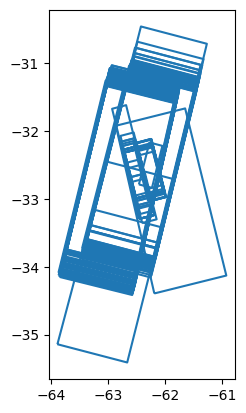

In [27]:
gdf.boundary.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>


<Axes: >

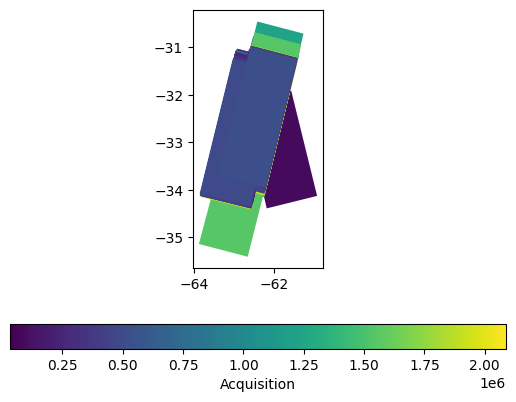

In [28]:
column2show = 'Acquisition'
print(type(gdf))
gdf.plot(column = column2show, legend=True, legend_kwds={"label": column2show, "orientation": "horizontal"})

In [29]:
# Lectura y apertura de kml que da origen a la búsqueda
def get_kml_name(search_folder):
    for file in os.listdir(search_folder):
        if file.endswith('.kml'):
            file2read = os.path.join(search_folder, file)
    return file2read
# Dado que se trata de un dato vectorial que se utilizó para búsqueda el algoritmo a implementar debe tomar solo la primera geometría
def get_wkt_V1(search_folder, verbose=False):
    file2read = get_kml_name(search_folder)
    # Primer versión de lector de wkt, busca la geometría del primer feature de la capa
    ds = ogr.Open(file2read, 0)
    if ds is None:
        sys.exit(f'No se puede abrir el archivo {fn}')
    lyr = ds.GetLayer(0)

    for feature in lyr:
        geometry = feature.GetGeometryRef()
        print('Tipo de geometría: ',geometry.GetGeometryName())
        geom_wkt = geometry.ExportToWkt()
        spatial_ref_auth = geometry.GetSpatialReference().GetAttrValue('AUTHORITY')
        spatial_ref_code = geometry.GetSpatialReference().GetAttrValue('AUTHORITY', 1)
        crs = spatial_ref_auth + ':' +  spatial_ref_code
        break
        # geom_list.append((geom_wkt, crs))
        # break00
    if verbose:
        # Visualización de campos disponibles
        print('Tipos de campos disponibles')
        for field in lyr.schema:
            print(field.name, field.GetTypeName(), sep ='\t'*2)
        # Visualización de tipo de geometría
        print()
        print('Tipo de geometría de capa: ', lyr.GetGeomType())
        print()
        print('Visualización de referencia espacial', lyr.GetSpatialRef(), sep = '\n')
        print()
        print('Visualización de geometrías')
        print(geometry.GetGeometryName())
        print(geometry.ExportToWkt())
        
    del ds
    return geom_wkt, crs

In [30]:
list2col = ['ROI_kml', 'Catalog_search', 'Output_file', 'Filter date']
f_page_dict = {}
for title in list2col:
    f_page_dict[title] = []
# Guardo nombre de kml de búsqueda
f_page_dict[list2col[0]].append(os.path.basename(get_kml_name(search_selected)))
# Guardo nombre de archivo de catálogo
f_page_dict[list2col[1]].append(os.path.basename(get_sreadsheet_name(search_selected)))
# Guardo nombre de archivo de salida
f_page_dict[list2col[2]].append(output_name)

# Guardo hora de procesamiento
x_date = datetime.now()
utc_arg_list = list(pytz.country_timezones['AR'])
# display(utc_arg_list)
# print(type(utc_arg_list[0]))
str_bsas = utc_arg_list[0]
# Muestro hora en nuestra banda horaria
tz_bsas = pytz.timezone(str_bsas)
t_utc = x_date.timestamp()

t_utc_bsas = datetime.fromtimestamp(t_utc, tz_bsas)
str_date = t_utc_bsas.strftime('%Y-%m-%d %H:%M:%S%z (%Z)')
f_page_dict[list2col[3]].append(str_date)
display(f_page_dict)

# Paso diccionario a dataframe a carátula (frontpage o fp)

df_fp = pd.DataFrame.from_dict(f_page_dict)

{'ROI_kml': ['Name_id_SanMarcosSud_6.kml'],
 'Catalog_search': ['20240826-1729_catalog_download.xlsx'],
 'Output_file': ['20240826-1729_filterd_search.xlsx'],
 'Filter date': ['2024-08-27 12:26:26-0300 (-03)']}

Tipo de geometría:  POLYGON


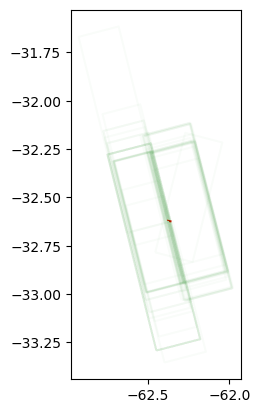

In [31]:
# Hacer prueba con kml multifeature para poder transformarlo en un polígono (toma también multipolígonos)
wkt_crs_tuple = get_wkt_V1(search_selected, False)

geom = shapely.wkt.loads(wkt_crs_tuple[0])
# print('Tipo de geometría (shapely): ',geom.geom_type)
if geom.geom_type == 'MultiPolygon':
    polygons = list(geom.geoms)
    # display('Separación de polígonos',polygons)
    pol = polygons[0]
else:
    pol = geom
pol_crs = wkt_crs_tuple[1]

# Visualización de polígono de búsqueda y de proyección para geopandas
# plt.plot(*pol.exterior.xy)
# print(wkt_crs_tuple[1])
# ya tengo el kml en shapely, ahora debo ingresarlos en modo gdf
roi_dict = {'col1': ['ROI busqueda'], 'geometry': [pol]}

roi2gdf = gpd.GeoDataFrame(roi_dict, crs=pol_crs)
# poly_search_gdb.plot(color='green', alpha=0.5)

# Visualización de frames de productos SAOCOM superpuestas a ROI de búsqueda

alpha_view = 1.1
gdf_strip = gdf.loc[gdf['Sensor mode'].isin(['STRIPMAP'])]
gdf_strip_qty = len(gdf_strip)
ax = gdf_strip.boundary.plot(color='green', alpha=alpha_view/gdf_strip_qty)

roi2gdf.plot(ax=ax, color='red', alpha=1)
plt.savefig(os.path.join(search_selected,'Stripmap.png'))

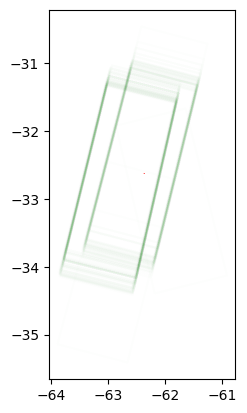

In [32]:
gdf_top = gdf.loc[gdf['Sensor mode'].isin(['TOPSAR'])]
gdf_top_qty = len(gdf_top)
ax = gdf.loc[gdf['Sensor mode'].isin(['TOPSAR'])].boundary.plot(color='green', alpha=alpha_view/gdf_top_qty)

roi2gdf.plot(ax=ax, color='red', alpha=1)
plt.savefig(os.path.join(search_selected,'TOPSAR.png'))

In [33]:
def resumer(gdf2proc):
    paths = gdf2proc['Grid Path'].unique()
    list2drop = []
    label2save = ['Sensor mode', 'Sensor submode', 'Grid Path', 'Grid Row', 'Qty prods', 'ROI_intersec', 'Initial date', 'Final date']
    dict2save = {}
    for label in label2save:
        dict2save[label] = []
    for s_path in paths:
        # Guardo gdf con un determinado número de path
        gdf_aux = gdf2proc.loc[gdf['Grid Path']==s_path]
        
        # Obtengo los números únicos de Row
        rows = gdf_aux['Grid Row'].unique()
        
        for row in rows:
            # Al df selecionado un path, ahora obtengo los números únicos de tipo de row
            gdf_p_r = gdf_aux.loc[((gdf_aux['Grid Path'] == s_path) & (gdf_aux['Grid Row'] == row))]
            
            # Coeficientes para informarme si hay productos reprocesados
            # Cantidad total de productos, pueden estar repetidos por día
            qty_prods = len(gdf_p_r)
            # print(f'Dataframe para Path: {s_path} y Row: {row}')
            # print(f'Cantidad de productos total {qty_prods}')
            
            # Obtengo lista de valores únicos
            prod_dates = gdf_p_r['Frame Start time'].unique()
            qty_unique_prods = len(prod_dates)
            # print(f'Cantidad de productos total {qty_unique_prods}')

            # Voy guardando datos de resumen
            # Modo
            dict2save[label2save[0]].append(gdf_p_r.iloc[0][label2save[0]])
            # Submodo
            dict2save[label2save[1]].append(gdf_p_r.iloc[0][label2save[1]])
            # Path
            dict2save[label2save[2]].append(s_path)
            # Row
            dict2save[label2save[3]].append(row)
            # Cantidad de productos únicos
            dict2save[label2save[4]].append(qty_unique_prods)
            # Promedio de cobertura por path y row, es errónea porque no quité todavía los productos que sobran pero es muy similar a este valor
            dict2save[label2save[5]].append(gdf_p_r[label2save[5]].mean())
            # Inicio de adquisición
            dict2save[label2save[6]].append(gdf_p_r['Frame Start time'].min())
            # Fin de adquisición
            dict2save[label2save[7]].append(gdf_p_r['Frame Start time'].max())

            # Proceso si los valores únicos son menores que el valor total
            if (qty_prods > qty_unique_prods):
                repeated_cond = gdf_p_r['Frame Start time'].duplicated(keep=False)
                
                # Separo dataframes por valores únicos de días, con el objetivo de borrar la de menor fecha de procesamiento
                repeat_date = gdf_p_r[repeated_cond]['Frame Start time'].unique()
                for date in repeat_date:
                    
                    # Separo filas de dataframe que tenga un día repetido
                    gdf_p_r_brdate = gdf_p_r.loc[(gdf_p_r['Frame Start time']) == date]

                    # Ordeno el reducido df por fecha de producción
                    gdf_p_r_brdate = gdf_p_r_brdate.sort_values(by = ['Production Start time'], ascending=False)
                    # display(gdf_p_r_brdate)

                    # Guardo valor de fila a tirar por repetido
                    ind = list(gdf_p_r_brdate.index)
                    # Quito el primer valor de la lista a quitar (dejo el último procesado)
                    ind_less_0 = ind[1:]
                    list2drop += ind_less_0
                    # print(f'Muestro los índices implicados para quitar los repetidos y dejar el último procesamiento\n{ind_less_0}')
    df_resume = pd.DataFrame.from_dict(dict2save).sort_values(by=['ROI_intersec', 'Sensor submode'], ascending=False)

    return gdf2proc.drop(index=list2drop), list2drop, df_resume

In [34]:
# Cómputo de superposición de áreas entre productos SAOCOM y ROI de búsqueda
# Genero el dataframe de intersección
inter_shapes = gdf.overlay(roi2gdf, how='intersection')
# inter_shapes['inter_area'] = inter_shapes.area
# Agrego columna de intersección
list2add = list(inter_shapes.area/pol.area)
# display(list2add)
# Lo agrego en ppio a geodataframe de interesección 'inter_shapes_2'
inter_shapes['ROI_intersec'] = list2add
# Ordeno productos por intersección de ROI y luego por instante inicial de adquisición
gdf = inter_shapes.sort_values(by=['ROI_intersec', 'Acquisition Start time'], ascending=False)
# Guardo las columnas que importan
gdf = gdf[["Product ID", "Parents ID", "ROI_intersec","Abstract", "Grid Path", "Grid Row", "Frame Start time", "Sensor mode", "Sensor submode", "Polarization", "Orbit type", "Production Start time"]]
# Verificación de que quito reprocesamientos
# Separo en dataframes más chicos,  seleccionados por "Grid Path y Row"

new_gdf, drop_list, resume_df = resumer(gdf)

# display(gdf)
# print('Cálculo de intersección de área')
# display(inter_shapes.area/pol.area)
# display(inter_shapes)

/tmp/ipykernel_44832/1969131115.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  list2add = list(inter_shapes.area/pol.area)


In [35]:
# Separo tablas por modo (stripmap y TOPSAR) y también guardo las columnas necesarias de Maximiliano Martinez
# TOPSAR
gdf_topsar = new_gdf.loc[new_gdf['Sensor mode'].isin(['TOPSAR'])]
# Stripmap
gdf_strip = new_gdf.loc[new_gdf['Sensor mode'].isin(['STRIPMAP'])]

# display(gdf_topsar, gdf_strip)

In [36]:
with pd.ExcelWriter(output_path) as writer:
    df_fp.to_excel(writer, sheet_name="Title", index=False)
    resume_df.to_excel(writer, sheet_name="Summary", index=False)
    new_gdf.to_excel(writer, sheet_name="Total", index=False)
    gdf_topsar.to_excel(writer, sheet_name="TOPSAR", index=False)
    gdf_strip.to_excel(writer, sheet_name="Stripmap", index=False)